# CSC411 Project 3

## Part 1 Preparation of data

In [1]:
import random
import numpy as np
import math

In [2]:
#prepare datasets
#designate 0 = fake, 1 = real for our labels

fake_data = "clean_fake.txt"
real_data = "clean_real.txt"

fake = []
for line in open(fake_data):
    l = line.rstrip('\n').split()
    fake.append(l)
    
real = []
for line in open(real_data):
    l = line.rstrip('\n').split()
    real.append(l)
    
random.seed(1)
random.shuffle(fake)
random.seed(1)
random.shuffle(real)

train_set, valid_set, test_set = [], [], []
train_label, valid_label, test_label = [], [], []

for i in range(len(fake)):
    if i < 0.7*len(fake):
        train_set.append(fake[i])
        train_label.append(0)
    elif i < 0.85*len(fake):
        valid_set.append(fake[i])
        valid_label.append(0)
    else:
        test_set.append(fake[i])
        test_label.append(0)

for i in range(len(real)):
    if i < 0.7*len(real):
        train_set.append(real[i])
        train_label.append(1)
    elif i < 0.85*len(real):
        valid_set.append(real[i])
        valid_label.append(1)
    else:
        test_set.append(real[i])
        test_label.append(1)

In [3]:
#check compositions
sum = len(train_set) + len(valid_set) + len(test_set)
print len(train_set) / float(sum)
print len(valid_set) / float(sum)
print len(test_set) / float(sum)


0.700244947949
0.150030618494
0.149724433558


In [5]:
#construct word frequency dictionary, 
#word_freq = {some_word, (num_label=0, num_label=1)}
word_freq = {}
for i in range(len(train_set)):
    unique_words = set(train_set[i])
    for word in unique_words:
        if word in word_freq:
            if train_label[i] == 0: 
                word_freq[word] = (word_freq[word][0]+1, word_freq[word][1])
            elif train_label[i] == 1: 
                word_freq[word] = (word_freq[word][0], word_freq[word][1]+1)
        else:
            if train_label[i] == 0: 
                word_freq[word] = (1, 0)
            elif train_label[i] == 1: 
                word_freq[word] = (0, 1)


In [6]:
#extract all prob_wi_g_fake, prob_wi_g_real
word_freq_list = word_freq.items()

#define hyperparameters
# m = 4.556423559251676
# p_hat = 0.05764749575838839
m = 0.0
p_hat = 0.0

#count number of fake instances
num_fake = train_label.count(0)
num_real = train_label.count(1)

prob_real = num_real / float(num_fake+num_real)
prob_fake = num_fake / float(num_fake+num_real)

#get prob of w_is given fake or real news
prob_w_g_fake = []
prob_w_g_real = []
words = []
not_prob_w_g_fake = []
not_prob_w_g_real = []
for word, freq in word_freq.iteritems():
    words.append(word)
    prob_w_g_fake.append((freq[0] + m*p_hat) / (num_fake + m))
    prob_w_g_real.append((freq[1] + m*p_hat) / (num_real + m))
    not_prob_w_g_fake.append(1 - ((freq[0] + m*p_hat) / (num_fake + m)))  
    not_prob_w_g_real.append(1 - (freq[1] + m*p_hat) / (num_real + m))


Neural Network Spam Classifier

In [7]:
#convert differents sets into vectors

#construct dictionary with each word having a unique label
word_dict = {}
i = 0
all_sets = train_set + valid_set + test_set
for sentence in all_sets:
    for word in sentence:
        if word not in word_dict:
            word_dict[word] = i
            i += 1

#convert each set to np matrices and vectors
def convert_to_mat(my_set, my_label, word_dict):
    num_unique_words = len(word_dict)
    mat_set = np.zeros((len(my_set), num_unique_words))
    vec_label = np.asarray(my_label).reshape((len(my_label),1))
    not_vec_label = 1 - vec_label
    vec_label = np.hstack((not_vec_label,vec_label))
    
    for i in range(len(my_set)):
        for word in my_set[i]:
            mat_set[i][word_dict[word]] = 1
            
    return mat_set, vec_label
        

In [8]:
x_train, y_train = convert_to_mat(train_set, train_label, word_dict)
x_valid, y_valid = convert_to_mat(valid_set, valid_label, word_dict)
x_test, y_test = convert_to_mat(test_set, test_label, word_dict)
print x_train.shape
print y_train.shape
print x_valid.shape
print y_valid.shape
print x_test.shape
print y_test.shape

(2287, 5832)
(2287, 2)
(490, 5832)
(490, 2)
(489, 5832)
(489, 2)


In [9]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt


In [10]:
# Define Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, 30)
        self.linear2 = nn.Linear(30, 100)
        self.linear3 = nn.Linear(100, num_classes)
    
    def forward(self, x):
        h_relu1 = self.linear1(x).clamp(min=0)
        h_relu2 = self.linear2(h_relu1).clamp(min=0)
        y_pred = self.linear3(h_relu2)
        return y_pred

In [11]:
def LR_model_L2(x_train, y_train, x_valid, y_valid, word_dict, reg_term=0.01):
    # Hyper Parameters 
    input_size = len(word_dict)
    num_classes = 2
    num_epochs = 500
    learning_rate = 0.001

    model_L2 = LogisticRegression(input_size, num_classes)

    x = Variable(torch.from_numpy(x_train), requires_grad=False).type(torch.FloatTensor)
    y = Variable(torch.from_numpy(np.argmax(y_train, 1)), requires_grad=False).type(torch.LongTensor)

    loss_fn = nn.CrossEntropyLoss()  
    #apply built-in L2 regularization 
    optimizer = torch.optim.Adam(model_L2.parameters(), lr=learning_rate, weight_decay=reg_term) 
    
    train_perf_list = []
    valid_perf_list = []
    epoch_list = []

    for epoch in range(num_epochs+1):

        optimizer.zero_grad()
        outputs = model_L2(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        
        if epoch % 50 == 0:
            #Print epoch
            print 'Epoch: [{}/{}]'.format(epoch, num_epochs)

            training_input = Variable(torch.from_numpy(x_train), requires_grad=False).type(torch.FloatTensor)
            prediction = model_L2(training_input).data.numpy()
            train_performance = (np.mean(np.argmax(prediction, 1) == np.argmax(y_train, 1)))
           
            valid_input = Variable(torch.from_numpy(x_valid), requires_grad=False).type(torch.FloatTensor)
            prediction = model_L2(valid_input).data.numpy()
            valid_performance = (np.mean(np.argmax(prediction, 1) == np.argmax(y_valid, 1))) 
        
        
            print "Training Set Performance: {}".format(train_performance)
            print "Validation Set Performance: {}".format(valid_performance)
            train_perf_list.append(train_performance)
            valid_perf_list.append(valid_performance)
            epoch_list.append(epoch)
            
    #plot the curves
    plt.plot(epoch_list, train_perf_list, label='Training Set')
    plt.plot(epoch_list, valid_perf_list, label='Validation Set')
    plt.title('Set Performance vs. Number of Iterations')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Set Performance')
    plt.legend()
    plt.show()

    return model_L2

Epoch: [0/500]
Training Set Performance: 0.602536073459
Validation Set Performance: 0.602040816327
Epoch: [50/500]
Training Set Performance: 0.932225623087
Validation Set Performance: 0.826530612245
Epoch: [100/500]
Training Set Performance: 0.990380411019
Validation Set Performance: 0.830612244898
Epoch: [150/500]
Training Set Performance: 0.997813729777
Validation Set Performance: 0.824489795918
Epoch: [200/500]
Training Set Performance: 0.999125491911
Validation Set Performance: 0.816326530612
Epoch: [250/500]
Training Set Performance: 0.999562745955
Validation Set Performance: 0.816326530612
Epoch: [300/500]
Training Set Performance: 0.999562745955
Validation Set Performance: 0.816326530612
Epoch: [350/500]
Training Set Performance: 0.999562745955
Validation Set Performance: 0.816326530612
Epoch: [400/500]
Training Set Performance: 0.999562745955
Validation Set Performance: 0.816326530612
Epoch: [450/500]
Training Set Performance: 0.999562745955
Validation Set Performance: 0.816326

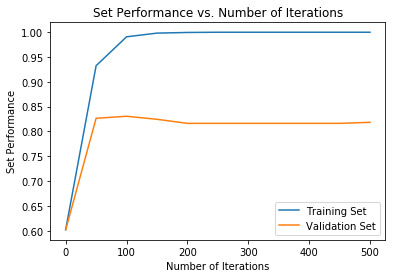

In [11]:
#train the model 
model_L2 = LR_model_L2(x_train, y_train, x_valid, y_valid, word_dict, 0.01)

In [16]:
#Test results
test_input = Variable(torch.from_numpy(x_test), requires_grad=False).type(torch.FloatTensor)
prediction = model_L2(test_input).data.numpy()
test_performance = (np.mean(np.argmax(prediction, 1) == np.argmax(y_test, 1)))
print(test_performance)

0.862985685072


Analyzing logistic regression results

In [13]:
#feed every word in word_dict into the network append activations to list called res
res = []
words = []
length = len(word_dict.keys())
for word in word_dict.keys():
    x_test = np.eye(1,length, k = word_dict[word])
    test_input = Variable(torch.from_numpy(x_test), requires_grad=False).type(torch.FloatTensor)
    prediction = model_L2(test_input).data.numpy()    
    words.append(word)
    res.append(prediction[0])

In [14]:
#max activation for fake
max_activation_fake = sorted(zip(words, res), key = lambda pair: pair[1][0], reverse=True)[0:10]
print [pair[0] for pair in max_activation_fake]

#max activation for real
max_activation_fake = sorted(zip(words, res), key = lambda pair: pair[1][1], reverse=True)[0:10]
print [pair[0] for pair in max_activation_fake]


['breaking', 'autistic', 'go', 'hillary', 'propaganda', 'won', 'watch', 'bored', 'victory', 'spy']
['trumps', 'tax', 'australia', 'turnbull', 'accept', 'speaks', 'us', 'business', 'hacking', 'korea']


In [16]:
#saving the model
torch.save(model_L2.state_dict(), 'weights')


In [15]:
#reload model
input_size = 5832
num_classes = 2
model_L2 = LogisticRegression(input_size, num_classes)
model_L2.load_state_dict(torch.load('weights'))


In [22]:
#save word_dict
import pickle

# Store data (serialize)
with open('filename.pickle', 'wb') as handle:
    pickle.dump(word_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)



True